# Generative adversarial network

In [46]:
import tensorflow as tf
from IPython import display
import time

In [2]:
tf.__version__

'2.15.0'

## Data Preprocessing

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [6]:
train_images.shape

(60000, 28, 28, 1)

In [7]:
train_images[0]

array([[[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
    

In [8]:
train_images = (train_images - 127.5) / 127.5

In [9]:
train_images[0]

array([[[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [

In [10]:
buffer_size = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(BATCH_SIZE)

In [11]:
images = next(iter(train_dataset))

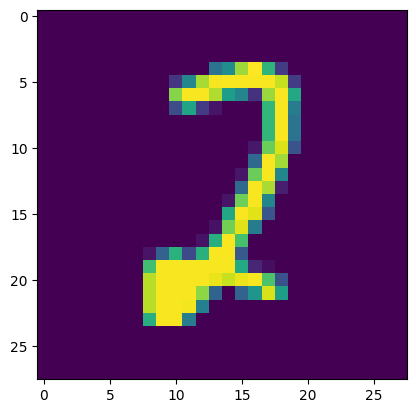

In [12]:
import matplotlib.pyplot as plt
plt.imshow(images[2])

## Create the models

### The Generator

In [13]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Reshape((7, 7, 256)))

  model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))

  return model

In [14]:
generator = make_generator_model()


In [15]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [16]:
noise = tf.random.normal([1,100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.18653436,  1.1244099 ,  1.5847309 , -2.3334308 ,  0.91365427,
         0.6028099 , -0.8489192 ,  1.0256598 , -0.61805606, -0.0973199 ,
         0.92249733, -1.1354457 ,  2.7075996 ,  0.5470849 , -0.12288245,
        -1.6948045 ,  0.11073089, -1.3459818 , -1.6491995 ,  0.63596874,
         0.04511409, -0.7170523 , -1.330646  ,  1.3441514 , -1.2391709 ,
         0.45933142, -0.8863004 ,  1.2040199 , -0.558635  , -0.7809022 ,
        -1.5116806 ,  0.21952756, -0.10812138,  0.87616634,  0.00309583,
         0.48278835,  0.1150998 , -0.543486  ,  1.1786752 , -1.9856359 ,
        -1.0381416 ,  0.5246397 ,  1.4349936 ,  0.02578266, -0.35213137,
        -0.24103567, -0.3304927 , -1.522948  ,  0.31200808,  1.065478  ,
         0.4722629 ,  0.6424392 , -1.3223956 ,  2.1671188 , -0.9556415 ,
        -0.65017265,  1.813385  ,  2.3298745 , -1.1618192 , -0.7767536 ,
         0.7736681 ,  1.2549208 ,  1.4318081 , -1.0159265 ,  0.38635662,
 

In [17]:
generated_image = generator(noise, training=False)

In [18]:
generated_image

<tf.Tensor: shape=(1, 28, 28, 1), dtype=float32, numpy=
array([[[[ 3.80731362e-04],
         [ 4.02262842e-04],
         [-3.13088764e-03],
         [-8.63339286e-04],
         [ 1.99714373e-03],
         [ 9.61779989e-03],
         [ 1.93436421e-03],
         [ 1.23648066e-03],
         [ 5.24026994e-03],
         [ 8.18305835e-03],
         [ 2.37768097e-03],
         [ 3.89495888e-03],
         [ 2.61128787e-03],
         [ 4.35761316e-03],
         [-3.44849238e-03],
         [ 4.44782712e-03],
         [ 7.27016106e-03],
         [ 7.66430516e-03],
         [-7.56718172e-03],
         [ 3.18357511e-03],
         [ 1.10184085e-02],
         [ 1.14239566e-02],
         [ 6.30201132e-04],
         [ 9.03423131e-03],
         [ 5.90420235e-03],
         [ 1.15532782e-02],
         [ 3.46627366e-03],
         [ 3.86397587e-03]],

        [[-3.16049554e-03],
         [-7.49451341e-04],
         [-8.52562720e-04],
         [ 7.27601256e-03],
         [-6.28746115e-04],
         [-1.12845

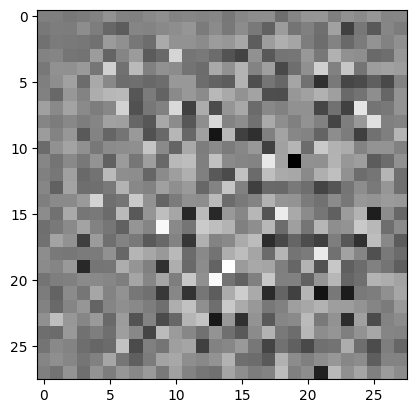

In [19]:
plt.imshow(tf.reshape(generated_image, (28, 28)), cmap='gray')

### Discriminator

In [20]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1))

  return model

In [21]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00023349]], dtype=float32)>

# define loss and optimizers

In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [24]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [26]:
import os
checkpoint_dir = './training_checkpoints/ckpt'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [27]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [43]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [48]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)

      display.clear_output(wait=True)
      generate_and_save_images(generator,
                               epoch+1,
                               seed)
      if(epoch+1) % 15 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
      print(f'time for epoch {epoch+1}, is {time.time()-start}')

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)

In [41]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

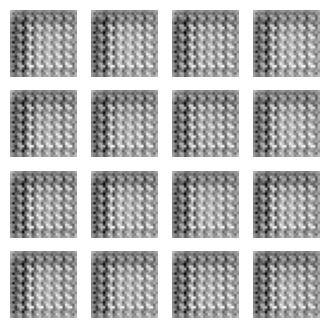

time for epoch 1, is 713.8771021366119


In [ ]:
train(train_dataset, EPOCHS)